In [1]:
%reload_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import pandas as pd
import mat73 as mt
import scipy.io as sio
import matplotlib.pyplot as plt

from fppnpx.preprocessing import read_session, load_waveforms, read_bin
from fppnpx.ChannelSignal import ChannelSignal
from fppnpx.plottools import MATMAP

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Read in data

In [3]:
# imecpath = Path('/home/mateoumaguing/Documents/MiscData/TibsCFD/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0')
imecpath = "/Users/mateouma/Desktop/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0"

npxsession = read_session(time_window=[100,123], imec_path=imecpath)

Loading session from /Users/mateouma/Desktop/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0
Reading metadata...
Reading channel information...
383 usable channels detected. Use `channel_map` to view usable channels.
Reading cluster information from kilosort...
Session loading complete.


In [4]:
waveformpath = "/Users/mateouma/Downloads/monkey datasets/20230630_DLPFCwaveforms.mat"
waveform_dataset, waveform_means = load_waveforms(waveformpath, npxsession)

Loading waveforms...
138 clusters with good waveforms detected.


## AP

In [7]:
ch208 = ChannelSignal(208, npxsession, bandtype='AP',
                      waveform_dataset=waveform_dataset,
                      time_halfbandwidth_product=3.5, compute_spectrogram=True)

Loading AP signal from channel 208...
Selecting good units...
Reading in time-series...
Notch filtering...
Computing multitapered spectrum...
Computing multitapered spectrogram...


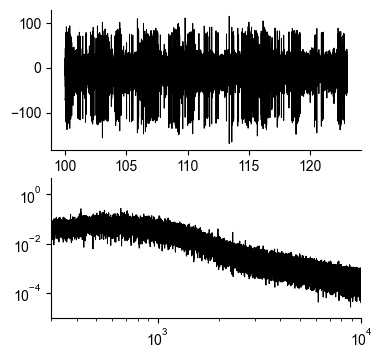

In [8]:
fig, ax = plt.subplots(2, figsize=(4,4))
ch208.plot_time_series(ax=ax[0])
ch208.plot_spectrum(log=True, ax=ax[1])

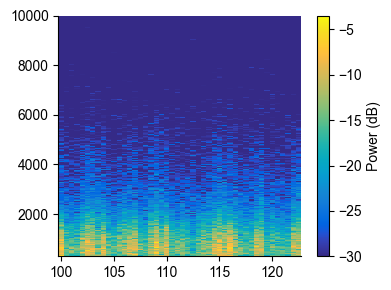

In [9]:
fig, ax = plt.subplots(figsize=(4,3))
spec = ch208.plot_spectrogram(vmin=-30, ax=ax)
plt.colorbar(spec, label='Power (dB)')
fig.tight_layout()

## LFP

In [ ]:
# parallelize this
channelSignalsLFP = {channel:ChannelSignal(channel, npxsession, bandtype='LFP', waveform_dataset=waveform_dataset, notch_filt=1, bandpass_filt=[15,500], compute_spectrum=False, verbose=False) for channel in npxsession["channel_map"]}

Loading LFP signal from channel 0...
Loading LFP signal from channel 1...
Loading LFP signal from channel 2...
Loading LFP signal from channel 3...
Loading LFP signal from channel 4...
Loading LFP signal from channel 5...
Loading LFP signal from channel 6...
Loading LFP signal from channel 7...
Loading LFP signal from channel 8...
Loading LFP signal from channel 9...
Loading LFP signal from channel 10...
Loading LFP signal from channel 11...
Loading LFP signal from channel 12...
Loading LFP signal from channel 13...
Loading LFP signal from channel 14...
Loading LFP signal from channel 15...
Loading LFP signal from channel 16...
Loading LFP signal from channel 17...
Loading LFP signal from channel 18...
Loading LFP signal from channel 19...
Loading LFP signal from channel 20...
Loading LFP signal from channel 21...
Loading LFP signal from channel 22...
Loading LFP signal from channel 23...
Loading LFP signal from channel 24...
Loading LFP signal from channel 25...
Loading LFP signal fro

Loading LFP signal from channel 208...
Selecting good units...
Reading in time-series...
Notch filtering...
Band-pass filtering beteen 0.5 and 500 Hz...
Computing multitapered spectrum...
Computing multitapered spectrogram...


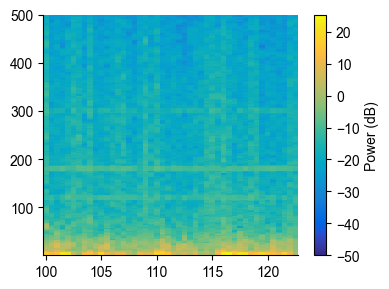

In [ ]:
ch208LFP = ChannelSignal(208, npxsession, bandtype='LFP', waveform_dataset=waveform_dataset,
                         notch_filt=1, bandpass_filt=[0.5,500], time_halfbandwidth_product=3,
                         compute_spectrogram=True, verbose=True)

fig,ax = plt.subplots(figsize=(4,3))
spec = ch208LFP.plot_spectrogram(vmin=-50, ax=ax)
plt.colorbar(spec, label='Power (dB)')
fig.tight_layout()

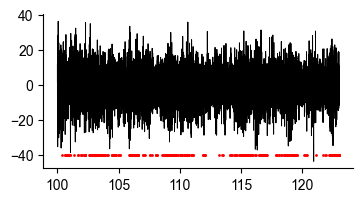

In [12]:
fig,ax = plt.subplots(figsize=(4,2))
channelSignalsLFP[208].plot_time_series(ax=ax)
ax.scatter(waveform_dataset[375]["spike_times"] / 30000, np.repeat(-40, waveform_dataset[375]["spike_times"].size), s=1, c='red')

In [46]:
def compute_cluster_spike_triggered_average(cluster, sta_window_len, session_dataset, channelSignalsLFP):
    channels_for_cluster = np.intersect1d(session_dataset["channels_for_clusters"][cluster], session_dataset["channel_map"])
    cluster_spike_times = session_dataset["cluster_spike_times"][cluster] / 30000 # spike times in seconds

    n_spks = len(cluster_spike_times)

    tstart,tend = session_dataset["time_window"]

    fsLFP = 2500

    sta_win_len_samp = sta_window_len * fsLFP

    st_time_axis = np.linspace(-sta_window_len/2, sta_window_len/2, int(sta_win_len_samp))

    cluster_sta = {}

    for channel in channels_for_cluster:
        channel_spike_trigs = []

        for spike_time in cluster_spike_times:
            if (tstart + sta_window_len) < spike_time < (tend - sta_window_len - 1/fsLFP):
                spike_time_idx = np.argmin(np.abs(channelSignalsLFP[channel].time_axis - spike_time))
                lfp_excerpt = channelSignalsLFP[channel].time_series[int(spike_time_idx - sta_win_len_samp/2):int(spike_time_idx + sta_win_len_samp/2)]

                channel_spike_trigs.append(lfp_excerpt)

        cluster_sta[channel] = np.mean(channel_spike_trigs, axis=0)

    return cluster_sta, n_spks, st_time_axis

In [28]:
unit_sample = np.random.choice(list(waveform_dataset.keys()), 25, replace=False)
unit_sample

array([ 22, 583, 257, 150, 247, 274,  52, 350, 374, 323, 339, 419,  17,
       298, 329, 272, 291, 496, 129, 336, 418, 523, 239, 287, 268])

/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/var/folders/nm/w2ptffz16jvdj7330zc_2btw0000gp/T/ipykernel_27535/1266974350.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6,3))


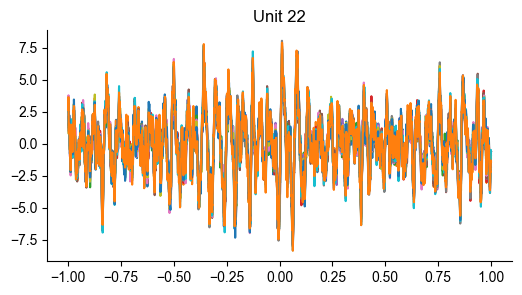

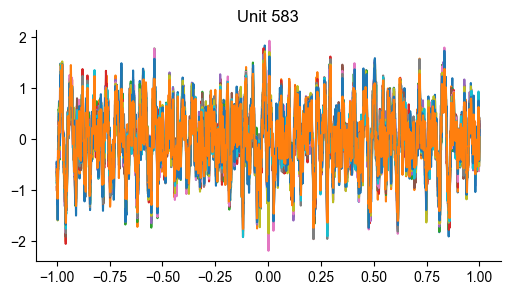

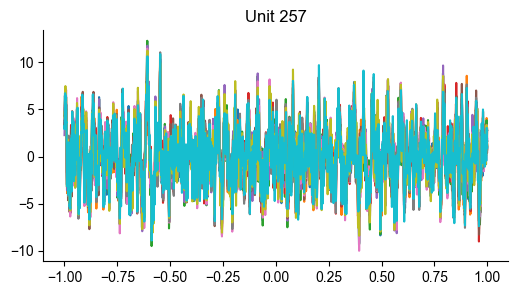

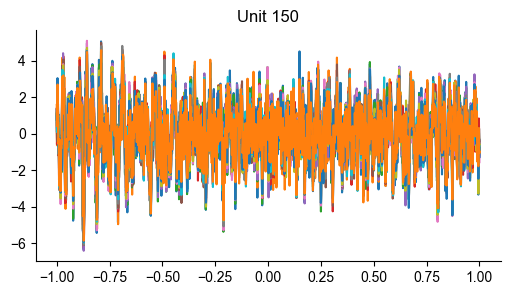

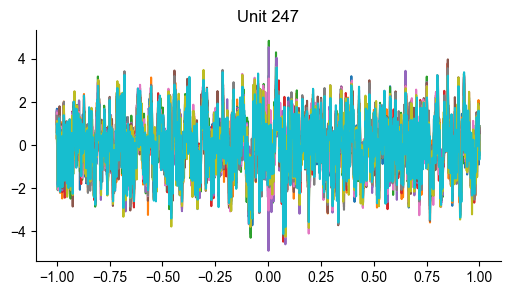

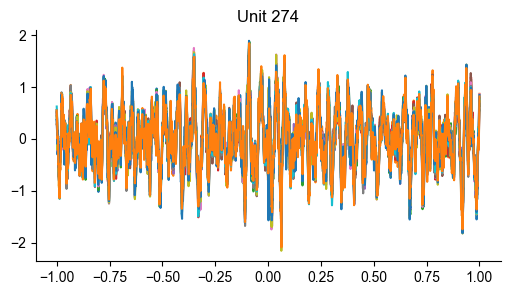

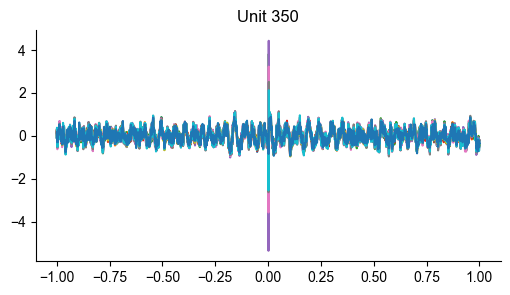

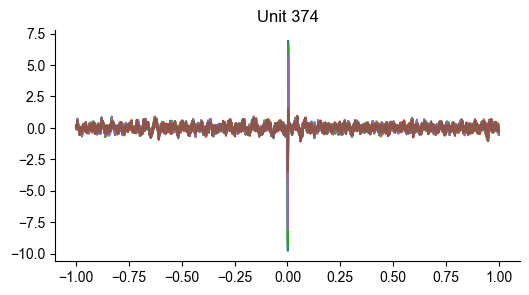

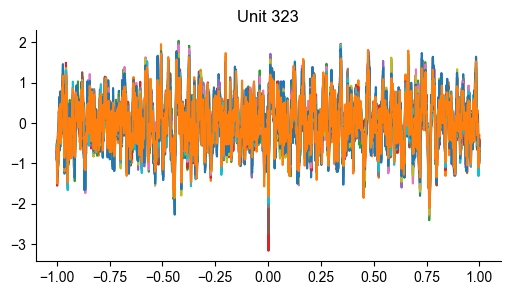

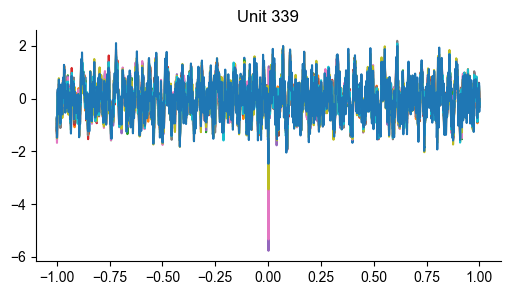

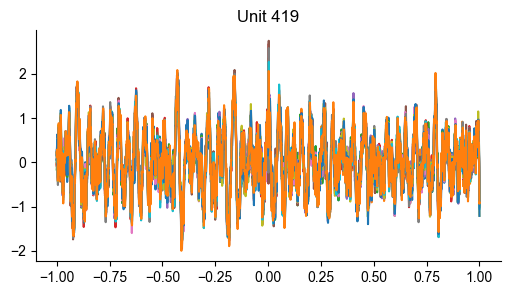

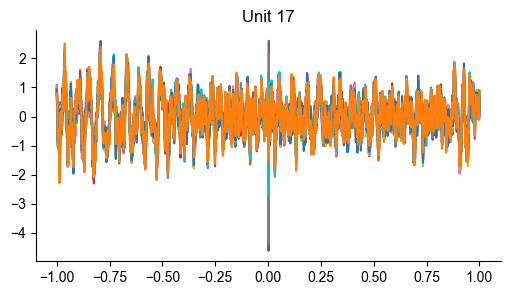

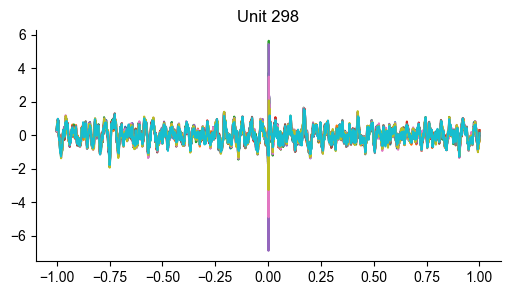

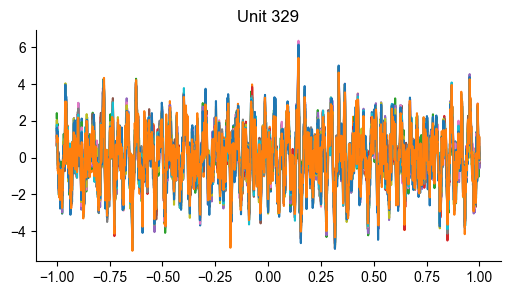

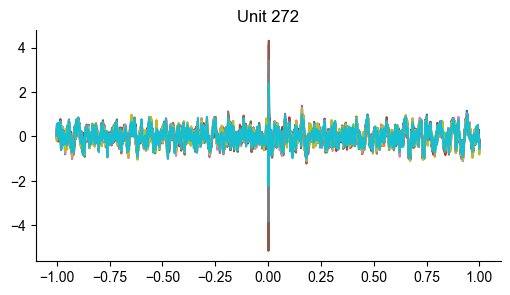

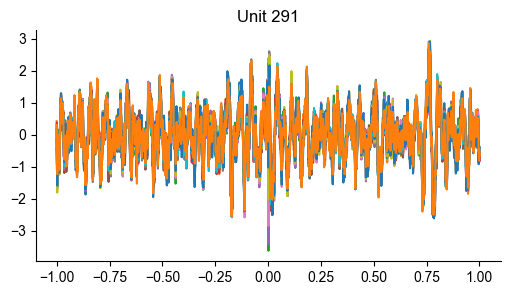

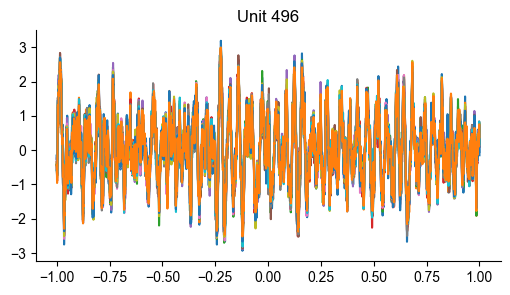

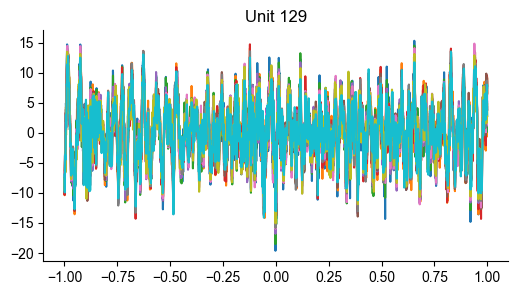

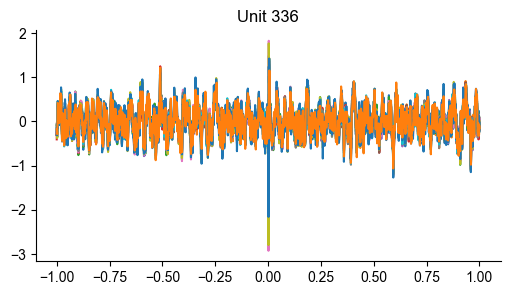

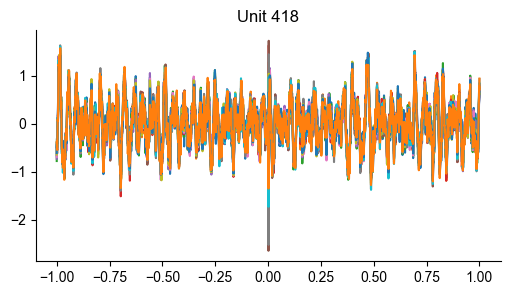

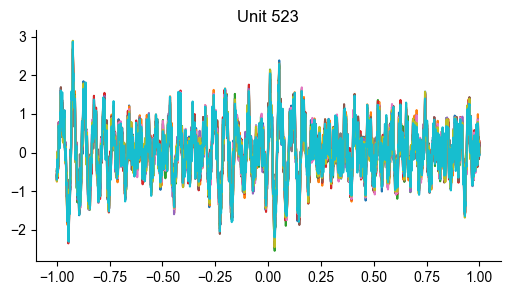

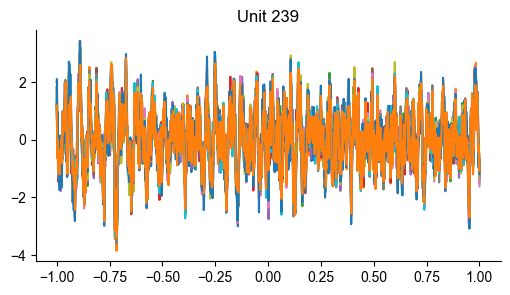

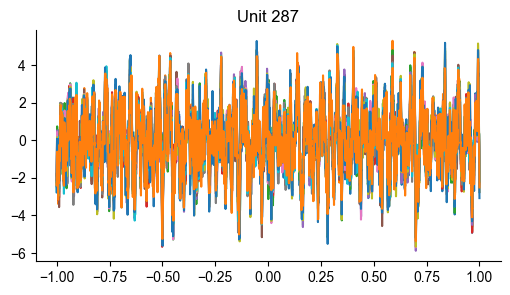

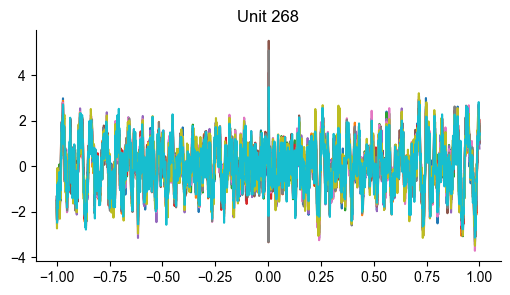

In [ ]:
for unit_OI in unit_sample:
    unit_sta,n_spks,st_time_axis = compute_cluster_spike_triggered_average(unit_OI, 2, npxsession, channelSignalsLFP)
    if n_spks == 0:
        continue
    fig, ax = plt.subplots(figsize=(6,3))
    for channel in unit_sta:
        ax.plot(st_time_axis, unit_sta[channel])
    ax.set_title(f"Unit {unit_OI} | {n_spks} spikes")